## Predicting Donors for a Charity

CharityML is a fictitious charity organization located in the heart of Silicon Valley in the USA that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML needs help build an algorithm to best identify potential donors and reduce overhead cost of sending mail.

In this project, my goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent.

To do this, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

My main objective with this project is to construct a model that accurately predicts whether an individual makes more than $50,000. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data
Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [43]:
# Import libraries 
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 

We will now establish:

- The total number of records, `'n_records'`
- The number of individuals making more than $50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most $50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than $50,000 annually, `'greater_percent'`.

In [44]:
# Dimensions of dataset
data.shape

(45222, 14)

In [45]:
# Income field
data.groupby(['income']).size()

income
<=50K    34014
>50K     11208
dtype: int64

In [46]:
# Total number of records
n_records = 45222

# Number of records where individual's income is more than $50,000
n_greater_50k = 11208

# Number of records where individual's income is at most $50,000
n_at_most_50k = 34014

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Descriptions**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Preparing & preprocessing the Data

Firstly we will do some initial checks of the state and validity of the data set.

In [47]:
# Lets check for data completeness/null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [48]:
# Now lets check some key stats to explore the range of values for each numerical feature
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [49]:
# Lets also check some values from top and bottom
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [50]:
data.tail()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


Fortunately, for this dataset, there appear to be no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features are likely to fit this description: '`capital-gain'` and `'capital-loss'`. 

Lets plot a histogram of these two features to see this more clearly.

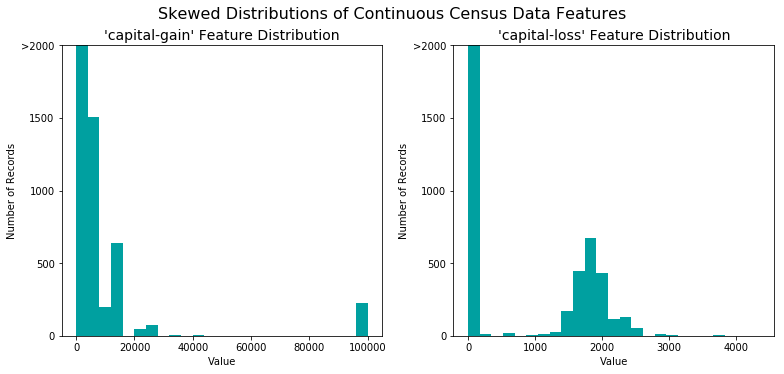

In [51]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

We will perform a transformation on the data and visualize the results. Note the range of values and how they are distributed after the transformation. 

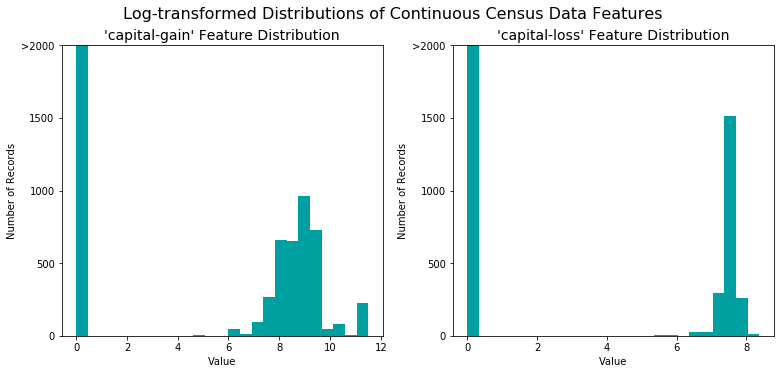

In [52]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will now normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [53]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [54]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.replace(['<=50K', '>50K'], [0, 1])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Show the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [55]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most 50K, and those that make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Definitions of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace

If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? this will act as our 'naive predictor' and benchmark for comparision with other models later.

When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 

Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [56]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
accuracy = np.sum(income) / n_records
recall = 1
precision = accuracy

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta_squared = 0.5 * 0.5
fscore = (1 + beta_squared) * ((precision * recall) / ((beta_squared * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Supervised Learning model selection

For this problem - I have judged the following features are appropriate & desirable in guiding the selection of a machine learning model, assuming the problem is to predict people who earn over 50k as a one-off prediction.

**Model criteria**

- **Memory & speed**: not primarily important but for what is feasible to be run within a notebook in a reasonable time, the aim is assumed to be a one off run of the model to predict rather than a model run continously where significant computational resources might be more an issue.
- **Not overfitting**: I would regard this as desirable/important, we want a model that generalises well, its only going to be run once and we want to maximise the predictive power on this one run to ensure the charities resources are least wasted in identifying only the most likely donors.
- **Time for learning/fitting**: like memory & speed, not so important beyond that which is reasonable to be run in the notebook without the browser timing out!
- **Time for predicting**: again like time for learning/fitting, not so important beyond what can be done in the notebook/browser.
- **Parameterisation**: slightly important. We will be using grid search later to optimise our solution, this will multiply the computational requirements used for a single model. Given the limit of our computatioal resources available in the notebook/browser a more simple parameterisation would allow the model to scale & deliver within this limited environment for a grid search.
- **Feature tolerance**: important, this dataset now has over 100 features, we would like a model that scales well in performance in relation to a large number of features.
- **Correlation tolerance**: important, this dataset now has over 100 features many of which may be correlated with each other. We would like a model that is more tolerant to this.

With these in mind, these are my selected models, their features - and the rationale for choosing them.

**Model 1 - LogisticRegression**

- **Strengths of model**: Fast to train, no parameter tuning, features don't need scaling, more tolerant to correlated features, excellent for 2-class classification problems
- **Weaknesses of model**: Not so good for large number of features, not good with non-linear decision boundries, not flexible enough to capture more complex relationships, adversely effected by features not relevent to output variable
- **Why model is a good candidate for this problem**: 1. The problem is a binary classification one, logistic regression is one of the best & simplest models for this kind of problem - worth considering occams razor! 2. The computational resources required for this model are low and ensure I can be certain this model will have no problem running in the notebook/browser on this dataset! I would like at least one of my models to be likely to run well with given computational resources. 3. Likely to be many correlated features in this 100+ feature dataset, this model should be more tolerant to these in generating predictions.

**Model 2 - AdaBoostClassifier**

- **Strengths of model**: Higher accuracy, handles lots of irrelavent features (does feature selection), handles correlated features, features don't need scaling, simple paramaterisation, not prone to overfitting/generalises well 
- **Weaknesses of model**: Can require large memory, slow training speed, sensitive to outliers & noisy data, not best in class (of boosting models) for many problems
- **Why model is a good candidate for this problem**: 1. One of the first successful boosting algorithms for binary classification with higher accuracy, which is desirable for our problem 2. Should be able to handle our 100+ features (potentially correlated) well 3. Simple paramaterisation should make optimisation phase with grid search more viable 4. Our cleaned & normalised data (outliers minimised & extreme values transformed) should minimise the weaknesses of this model in this respect.

**Model 3 - GradientBoostingClassifier**

- **Strengths of model**: Can handle big datasets, very accurate, can approximate most non-linear classification boundries, one of best boosting models for many classification problems (best in class), similar pros to adaboost (no need to transform features)
- **Weaknesses of model**: Slow to train (concern over available resources in notebook/browser sufficient?), prone to overfitting, not easy to understand, similar weaknesses to adaboost i.e. sensitive to outliers & noisy data, parameterisation can make a real difference to performance - therefore could be more work/fiddly to optimise & get best results.
- **Why model is a good candidate for this problem**: 1. This model is one of the most popular (getting some of the best results) models for classification problems - worth serious consideration! 2. Should be able to handle our 100+ features (potentially correlated) well 3. Paramaterisation can make a real difference to performance with this model, good chance of improvement in optimisation/grid search phase for one of the best solutions (assuming computational resources of notebook/browser sufficient).

**References**

I found the following tables & cheatsheets particularly useful in selecting my models:

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

https://blogs.sas.com/content/subconsciousmusings/2017/04/12/machine-learning-algorithm-use/

https://www.dataschool.io/comparing-supervised-learning-algorithms/

https://recast.ai/blog/machine-learning-algorithms/2/

I also found the following references useful for addtional information on various models:

https://elitedatascience.com/machine-learning-algorithms

https://semanti.ca/blog/?the-most-important-machine-learning-algorithms

https://towardsdatascience.com/a-tour-of-the-top-10-algorithms-for-machine-learning-newbies-dde4edffae11

https://scikit-learn.org/stable/modules/ensemble.html

http://rob.schapire.net/papers/explaining-adaboost.pdf

https://www.analyticsvidhya.com/blog/2015/05/boosting-algorithms-simplified/

https://courses.cs.washington.edu/courses/cse455/16wi/notes/15_FaceDetection.pdf

http://user.ceng.metu.edu.tr/~tcan/ceng734_f1112/Schedule/adaboost.pdf

https://www.psiweb.org/docs/default-source/default-document-library/guiyuan-lei-slides.pdf?sfvrsn=2526dedb_0

### Implementation - Creating a Training and Predicting Pipeline

In this section we will create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [57]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

We will now apply the training and predicting pipeline to our 3 candidate models:

- LogisticRegression
- AdaBoostClassifier
- GradientBoostingClassifier

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


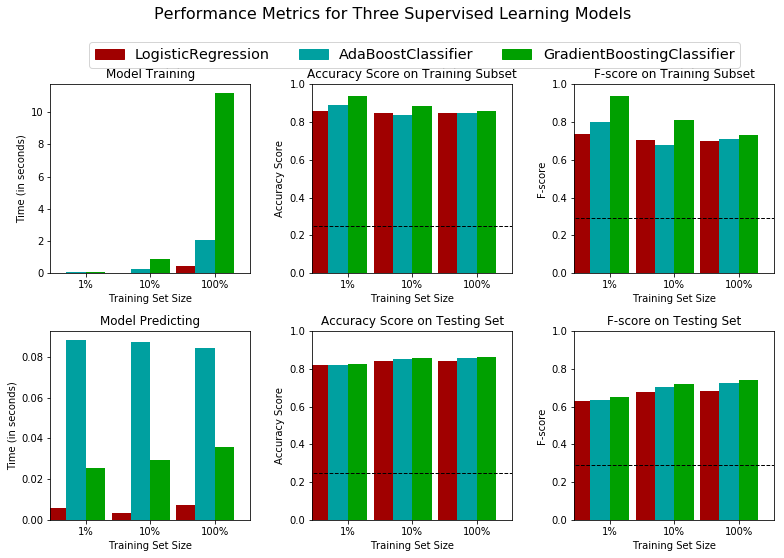

In [58]:
# Import the three supervised learning models from sklearn
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Initialize the three models
clf_A = linear_model.LogisticRegression(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int((samples_100 / 100) * 10)
samples_1 = int((samples_100 / 100) * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

In this final section, I will choose from the three supervised learning models the *best* model to use on the data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) tuning several meta-parameters to try and improve upon the untuned model's F-score. 

### Which is the Best Model?

Considering the evaluation of the 3 candidate models, I would reccomend use of the GradientBoostingClassifier (GBC) as the best model for identifying individuals who make more than \$50,000 for a number of reasons.

Firstly, the GBC achieves the highest F-Score on 100% the testing set (approx 0.74) of all the models. Second, the GBC also gets the highest F-Score when 100% of the training set is used (of a similar value). In fact the margin of difference between the models for the training and test sets is bigger, i.e. for the test set the GBC is even better than the next best model (Ada boost) than with the training data - suggesting the GBC model generalises the best for new data.

Second, while the GBC training & prediction time is high - given for our case we assume we will only run the model once or very occasionally, it is only a small inconveience to wait a little longer for the one use of this algorithm, and a small price to pay considering the improved peformance of prediction.

Thirdly, the GBC has a good record of performing well for a range of classification problems. Particular features of this model are that it can handle a large number of parameters, large data sets, and yet achieve high accuracy. While currently it is envisaged that this model be run only once - should the charity wish to run the same prediction in future with either larger datasets or datasets with even more features - this same model should perform well in these cases also.

Lastly we can also see that the accuracy score for both the training & test sets is highest for GBC, another measure (tho not as important as the F-Score) of generally how well the model performs compared to the other models.

### Describing the Model in Layman's Terms

The GradientBoostingClassifier is regarded as an 'ensemble' learner - what this means is it consists of multiple  'weak leaners' working together to combine to become something can be very good at predicting i.e. a 'strong learner'.

But what is a weak learner? what makes a good one for these boosting models? and how exactly are they combined? 

If we think about the problem at hand, how to predict if someone earns over 50,000 dollars - based on many input features (such as age, education, etc) this actually consists of multiple sub-problems e.g. is age a good predictor of income, and if so in what way? a weak learner aims to simply become better that random guessing at one of these sub-problems. Of course, you could make a weak learner that simply said whatever someones age, say they earn less than $50K - but this is not really any better than guessing so we would not consider or use this as a weak learner. 

The best weak learners are actually ones that do a very good job of predicting a particular sub-problem very well, however narrow. The training process is then a matter of finding one weak learner that solves one part of the problem very well, then finding another weak learner that solves a different part of the problem very well, and so on, until the entire problem is solved.

For example, if we found a weak learner that was good at predicting if individuals between the ages of 50-53 were likely to earn over \$50,000 or not - this would be quite useful. We could then look for other weak learners which might be good at solving the remaining sub-problems (e.g. a weak learner that was say good at predicting for ages 45-49, or for specific educational levels) until you get a good overall result from the combination of all these weak learners. So in a way, a good weak learner is a specialist or expert - something very good at doing a specific job very well. It is the combination of these many weak learner/specialists/experts, each focussing and doing a good job on a different part of the overall problem - that gives this model its real power that can result in an overall model that is a good learner/expert/predictor for the entire problem - like a team of experts.

Many types of machine learning algorithm can be used as the basis for weak learners, but the most common is what is called a 'decision tree' and this will be used in our solution.

When the model is used, i.e. is presented with new data, each of the weak learners it contains gets to vote on the data supplied (with their respective voting weights from the training phase applied) and in essence a kind of democracy results with the most votes deciding which category the new data falls into - i.e. when the model predicts we input all the features (age, education etc), the weak learners all look at this data and vote for if they they that person earns over or under \$50,000 - and the result with the most (& biggest votes) is the prediction made by the model overall.


### Model Tuning

We will now attempt to optimise the model by tuning several parameters using grid search.

In [59]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)

# Create the parameters we want to tune
parameters = {'n_estimators': [10, 50, 300], 'learning_rate': [0.1], 'max_depth': [6], 'min_samples_split': [100], 'warm_start': [True], 'subsample': [0.8], 'min_samples_leaf': [40]} 
    
# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print(grid_fit.best_estimator_.get_params)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=40, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=0, subsample=0.8, verbose=0,
              warm_start=True)>
Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8671
Final F-score on the testing data: 0.7455


### Final Model Evaluation

|     Metric     | Benchmark Model | Unoptimized Model | Optimized Model |
| :------------: | :---------------|:---------------:  | :-------------: | 
| Accuracy Score |    0.2478       |    0.8630         |     0.8671      | 
| F-score        |    0.2917       |    0.7395         |     0.7455      | 

The unoptimized model performs significantly better on both accuracy and F-score than the benchmark model. However the optimised model achieved only marginal improvement from the unoptimized for both Accuracy and F-score, increasing by less than 1% for both accuracy and F-score. 

This suggests that while the Gradient Boosting Classifier does hugely better than the benchmark, I was only able to optimise it by small amount - tho the optimised was better (if slightly).

----
## Feature Importance

We will now explore which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Intuition

When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Before we determine what the top 5 features actually are - my best initial guesses for what these might be and why are the following (in order of importance).

1. Occupation - I think this could be key as different occupations have associated salary bands (good for prediction)
2. Education - An indirect indication of potential salary, would expect good correlation
3. Age - Another factor, in general this can interact with other features to increase salary (would expect)
4. Sex - Sadly, due to sexism, gender may also be a good predictor of better salary in general
5. Native country - Due to the wealth disparity between countries, this also may be a good predictor of salary

### Implementation - Extracting Feature Importance

We will now extract the top 5 features from our final model.

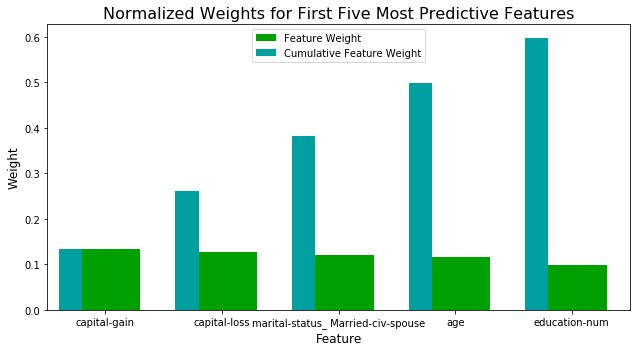

In [60]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier

# Train the supervised model on the training set 
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importances 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

It is interesting to compare my intuitions to the models most relevant features for predicting salary. Certainly I was very close with predicting age, where I put it as number 3 and the model ranked it as number 2. Also on education, while I picked education, the model found education-num as the best predictor feature of all.

However I completely missed the other 3: capital-gain, capital loss and married-civ-spouse. Looking again at these feature definitions:

**education-num**: continuous.

**marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

**capital-gain**: continuous.

**capital-loss**: continuous.

We can see how education could be converted into a continous variable, and so it seems - this is a far more useful predicator than education converted into a categorical variable (as with education). Perhaps expressed as a more linear relationship (continous variable) education makes a better predicator, than many one-hot-encoded categorical variables for education which are treated as separate/unrelated?

The Married-civ-spouse is also surprising - I honestly would have thought for example if anything, a single person for example would be a better predictor! Or maybe its the converse, perhaps being married is an inverse predictor of earning 50k (ie and indication that they don't have much spare cash due to being married!).

For capital gain & capital loss 'continuous' does not tell us much. Looking at the definition of these terms:

https://economictimes.indiatimes.com/definition/capital-gainloss

Gives us more insight to these terms, which mean:

**Capital gain** - is the profit one earns on the sale of an asset like stocks, bonds or real estate. It results in capital gain when the selling price of an asset exceeds its purchase price. It is the difference between the selling price (higher) and cost price (lower) of the asset. 

**Capital loss** - arises when the cost price is higher than the selling price. 

This now gives a bit more insight why these features might be good predictors of if someones income is higher or lower than \$50K.


### Feature Selection

How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. Below we will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [61]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8671
F-score on testing data: 0.7455

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7301


### Effects of Feature Selection

Considering the feature space is reduced down hugely from 103 to 5 features, the corresponding loss in accuracy and F-score is surprisingly minimal - loosing only 1% in accuracy and 1% in F-score.

If training time was a significant factor, using this reduced data set would definately be a consideration - given the tiny loss in predictive performance.

## Conclusion

We succeded in creating a model that had a reasonably good accuracy and F-score (0.87 & 0.75 respectively) for predicting potential donors for CharityML that earn over \$50,000. This model is ready to be used.

If further time was available, we could attempt to further tune the model parameters to see if we could further improve it's performance. Our particular model chosen (Gradient Boosting) could be deployed several times, and could even be applied to significantly bigger datasets and still should scale in terms of performance relatively well.